In [1]:
import urllib
import zipfile
import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
data_dir = Path('../data/')
data_dir.mkdir(exist_ok=True, parents=True)
if not data_dir.exists():
  urllib.request.urlretrieve('https://docs.google.com/uc?export=download&id=1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70', data_dir/'Denoising_Data.zip')
  with zipfile.ZipFile(data_dir / 'Denoising_Data.zip', 'r') as zip_ref:
     zip_ref.extractall(data_dir)

In [3]:
# load training data, used to update CNN weights
# 2000 30x30 image patches from 8 patients
train_input = np.load(data_dir/'Denoising_Data/train_input.npy')
train_target = np.load(data_dir/'Denoising_Data/train_target.npy')
# load validation data, used to monitor for overfitting
# 1000 30x30 image patches from 1 patient
val_input = np.load(data_dir/'Denoising_Data/val_input.npy')
val_target = np.load(data_dir/'Denoising_Data/val_target.npy')

# load testing data, used for evaluating performance
# 5 512x512 images from 1 patient
test_input = np.load(data_dir/'Denoising_Data/test_input.npy')
test_target = np.load(data_dir/'Denoising_Data/test_target.npy')

# Load examples images from state-of-the-art CNN denoising for CT images
test_example = np.load(data_dir/'Denoising_Data/test_input_denoised.npy')

print('Data loading completed.')

Data loading completed.


In [4]:
# This is a helper function that plots images using typical CT windows
def ctshow(img, window='soft_tissue'):
  # Define some specific window settings here
  if window == 'soft_tissue':
    ww = 400
    wl = 40
  elif window == 'bone':
    ww = 2500
    wl = 480
  elif window == 'lung':
    ww = 1500
    wl = -600
  else:
    ww = 6.0 * img.std()
    wl = img.mean()

  # Plot image on clean axes with specified window level
  vmin = wl - ww // 2
  vmax = wl + ww // 2
  plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])

  return

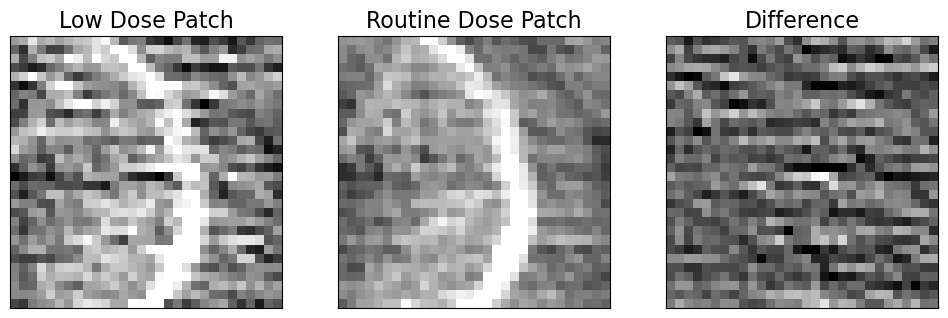

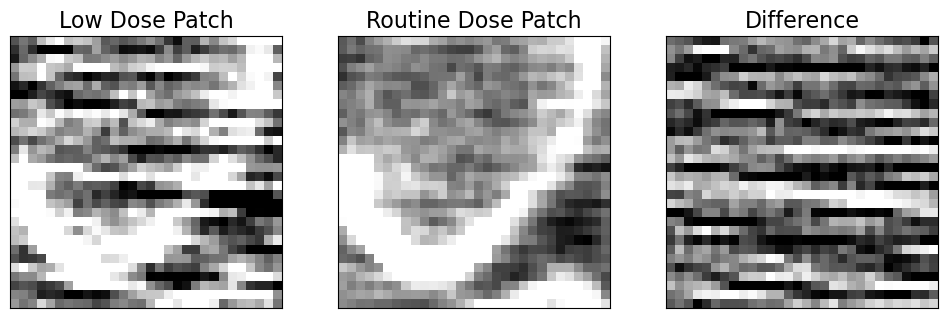

In [5]:
#Cell 5

# Get a few examples of training patches
image_examples = [3, 16, 36]
window = 'soft_tissue'

for row in range(2):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  # Simulated low-dose example
  plt.subplot(3, 3, 1+row*3)
  plt.title('Low Dose Patch', fontsize=16)
  ctshow(train_input[nexample, :, :, 0], window=window)

  # Simulated routine-dose example
  plt.subplot(3, 3, 2+row*3)
  plt.title('Routine Dose Patch', fontsize=16)
  ctshow(train_target[nexample, :, :, 0], window=window)
  plt.subplot(3, 3, 3+row*3)

  # Difference between low-dose and routine-dose to visualize CT noise
  plt.title('Difference', fontsize=16)
  ctshow(train_target[nexample, :, :, 0] - train_input[nexample, :, :, 0],
           window=window)

In [6]:
n_layers = 6
filters = 64
kernel_size = (3, 3)
strides = (1, 1)
activation = 'relu'

def build_model():
    xin = keras.layers.Input(shape=(None, None, 1), name='input_CT_images')
    # We define a preprocessing layer to rescale the CT image pixel values
    shift_mean = train_input.mean()
    rescale = train_input.std()
    x = keras.layers.Lambda(
        lambda x: (x - shift_mean) / rescale,
        name='normalization')(xin)

    for i in range(n_layers - 1):
        x = keras.layers.Conv2D(
          filters=filters,
          kernel_size=kernel_size,
          strides=strides,
          padding='same')(x)
        x = keras.layers.Activation(activation)(x)
    # Final layer has just one feature map corresponding to the output image
    x = keras.layers.Conv2D(
        filters=1,
        kernel_size=kernel_size,
        strides=strides,
        padding='same')(x)
    # Here we rescale the output to typical CT number range
    xout = keras.layers.Lambda(
        lambda x: (x * rescale) + shift_mean,
        name='output_CT_images')(x)
    # We define the model by specifying the inputand output tensors
    model = keras.Model(inputs=xin, outputs=xout, name="CT_denoiser")
    return model

In [7]:
noise_patch_dir = Path('../noise_patches')
# diameters = [112, 131, 151, 185, 200, 216, 292, 350]
diameters = [151]
noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
noise_patch_dict = {f.stem: np.load(f) for f in noise_files}
noise_patches = np.concatenate(list(noise_patch_dict.values()))
# noise_patches = np.zeros_like(noise_patches)

In [8]:
def augment(image_label, seed, max_noise=1):
  image, label = image_label
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  noise_patch = noise_patches[np.random.choice(list(range(len(noise_patches))))][:,:,None]
  noise_lambda = tf.random.uniform([1], minval=0, maxval=max_noise)

  add_noise = tf.random.uniform([1], minval=0, maxval=1) > 0.5
  if add_noise:
    image = label + noise_lambda[0]*noise_patch
    # image = image + noise_lambda[0]*noise_patch
  return image, label

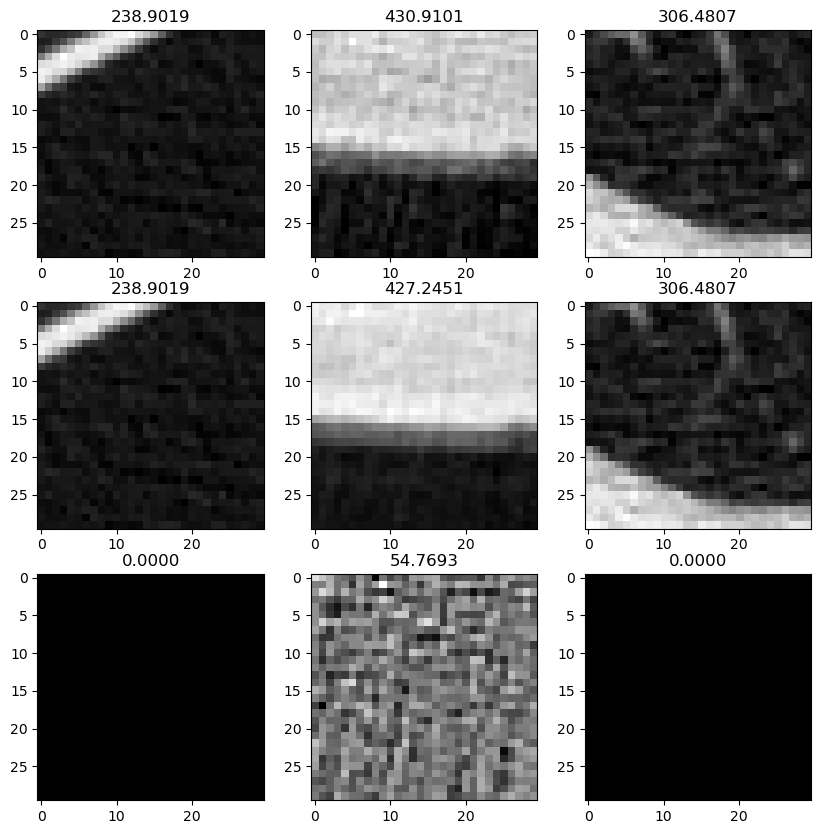

In [9]:
batch_size = 32
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

rng = tf.random.Generator.from_seed(123, alg='philox')
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(3):
    img = np.array(images[i])
    aug_image = f(img, labels[i])[0]

    axs[0, i].imshow(img[:,:,0], cmap='gray')
    axs[0, i].set_title(f'{img.std():0.4f}')
    axs[1, i].imshow(aug_image[:,:,0], cmap='gray')
    axs[1, i].set_title(f'{np.array(aug_image).std():0.4f}')
    diff = aug_image - img
    axs[2, i].imshow(diff[:,:,0], cmap='gray')
    axs[2, i].set_title(f'{np.array(diff).std():0.4f}')

In [10]:
batch_size = 32
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

rng = tf.random.Generator.from_seed(123, alg='philox')
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

denoising_model = build_model()
learning_rate = 0.0001
optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate)
denoising_model.compile(optimizer=optimizer, loss='mse')

# This sets the number of iterations through the training data
epochs = 15
batch_size = 32
learning_rate = 0.0001
optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate)

progress_example = 2
buffer = 128
progress_ims = []

AUTOTUNE = tf.data.AUTOTUNE

def train(loss_function, model, augment_training=False):

    train_ds = (
        train_dataset
        .map(f, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    ) if augment_training else (
        train_dataset
       .prefetch(AUTOTUNE)
    )
    model.compile(optimizer=optimizer, loss=loss_function)

    # As the training progresses, we'll monitor network output and performance
    # metrics. Some related variables are initialized here
    example_input = test_input[[3], ...]
    edge_buffer = 128
    progress_ims = []
    progress_val = []

    for epoch in range(epochs):
      # Evaluate model on reserved data
      val_loss = model.evaluate(val_input, val_target)
      example_output = model.predict(example_input)
      example_img = example_output[0, edge_buffer:-edge_buffer,
                                edge_buffer:-edge_buffer, 0]
      progress_ims.append(example_img)
      progress_val.append(val_loss)
      # Update model weights using training data
      istart = 0
      while istart < (len(train_input) - batch_size):
        for x, y in train_ds.take(1):
            model.train_on_batch(x=x, y=y)
        istart += batch_size

    progress_ims = np.stack(progress_ims, axis=0)

    print('Training phase complete.')
    return model, progress_ims, progress_val

/home/brandon.nelson/miniconda3/envs/peds_aug_tensorflow/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

denoising_model = build_model()
denoising_model.compile(optimizer=optimizer, loss='mse')
base_model, base_progress_ims, base_progress_val = train(loss_function='mse', model=denoising_model, augment_training=False)

1/1 [==============================] - 8s 8s/step


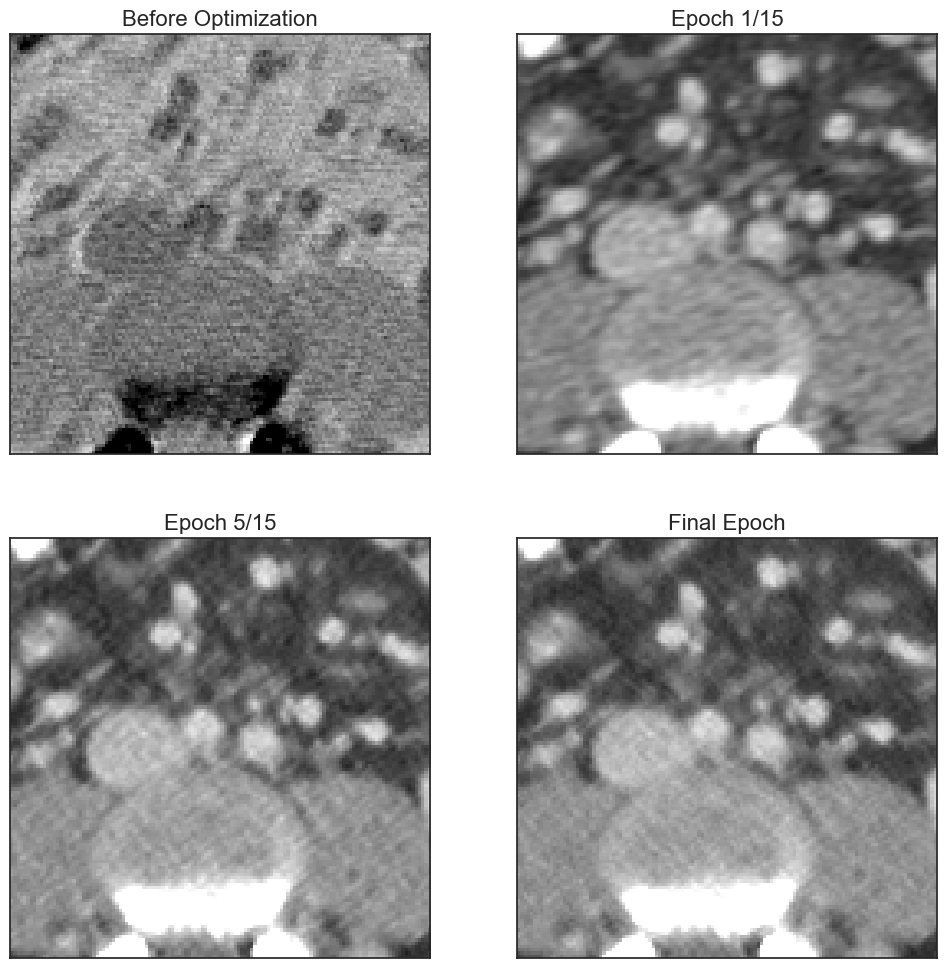

In [ ]:
#Cell 8

# Here we show some example images from different epochs in the training
# procedure.

def check_progress_ims(progress_ims):
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.title('Before Optimization', fontsize=16)
    ctshow(progress_ims[0, :, :], window='variable')

    plt.subplot(2, 2, 2)
    plt.title('Epoch %d/%d' %(1, epochs), fontsize=16)
    ctshow(progress_ims[1, :, :], window='soft_tissue')

    plt.subplot(2, 2, 3)
    plt.title('Epoch %d/%d' %(5, epochs), fontsize=16)
    ctshow(progress_ims[5, :, :], window='soft_tissue')

    plt.subplot(2, 2, 4)
    plt.title('Final Epoch', fontsize=16)
    ctshow(progress_ims[-1, :, :], window='soft_tissue')

In [ ]:
check_progress_ims(base_progress_ims)

## Now with augmentation

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

denoising_model = build_model()
denoising_model.compile(optimizer=optimizer, loss='mse')
aug_model, aug_progress_ims, aug_progress_val = train(loss_function='mse', model=denoising_model, augment_training=True)

In [ ]:
check_progress_ims(aug_progress_ims)

In [ ]:
nexample = 1
CNNout = denoising_model.predict(test_input, batch_size=1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[nexample, :, :, 0])

plt.subplot(1, 3, 2)
plt.title('Estimated Noise Map', fontsize=16)
ctshow(test_input[nexample, :, :, 0] - CNNout[nexample, :, :, 0])

plt.subplot(1, 3, 3)
plt.title('CNN Denoised Image', fontsize=16)
ctshow(CNNout[nexample, :, :, 0])

# Same as above, but with a different field of view
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Gaussian Filter', fontsize=16)
gaussfilt = ndimage.gaussian_filter(test_input[3, :, :, 0], sigma=1.4)
ctshow(gaussfilt[110:-110, 50:-50])

plt.subplot(1, 2, 2)
plt.title('CNN Denoised, MSE', fontsize=16)
ctshow(CNNout[3, 110:-110, 50:-50, 0])